In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [ ]:
from typing import List
import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
plt.switch_backend('agg')

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5

#############################################################
# convert datetime data into value between -0.5 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])


def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))


def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    d += 1e-12
    return 0.01*(u / d).mean(-1)


def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse = RSE(pred, true)
    corr = CORR(pred, true)

    return mae, mse, rmse, mape, mspe, rse, corr

def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    elif args.lradj == '3':
        lr_adjust = {epoch: args.learning_rate if epoch < 10 else args.learning_rate*0.1}
    elif args.lradj == '4':
        lr_adjust = {epoch: args.learning_rate if epoch < 15 else args.learning_rate*0.1}
    elif args.lradj == '5':
        lr_adjust = {epoch: args.learning_rate if epoch < 25 else args.learning_rate*0.1}
    elif args.lradj == '6':
        lr_adjust = {epoch: args.learning_rate if epoch < 5 else args.learning_rate*0.1}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


class StandardScaler():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean


def visual(true, preds=None, name='./pic/test.pdf'):
    """
    Results visualization
    """
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')

def test_params_flop(model,x_shape):
    """
    If you want to thest former's flop, you need to give default value to inputs in model.forward(), the following code can only pass one argument to forward()
    """
    model_params = 0
    for parameter in model.parameters():
        model_params += parameter.numel()
        print('INFO: Trainable parameter count: {:.2f}M'.format(model_params / 1000000.0))
    from ptflops import get_model_complexity_info
    with torch.cuda.device(0):
        macs, params = get_model_complexity_info(model.cuda(), x_shape, as_strings=True, print_per_layer_stat=True)
        # print('Flops:' + flops)
        # print('Params:' + params)
        print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        print('{:<30}  {:<8}'.format('Number of parameters: ', params))


# PrepareData for "S"

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='updated_measurement_Iclr.csv',
                 target='I', scale=True, timeenc=0, freq='t', train_only=False):

        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.train_only = train_only

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv('/content/drive/MyDrive/updated_measurement_Iclr.csv')
        df_raw['Datetime'] = df_raw['Datetime'].str.replace('+07:00', '', regex=False)
        df_raw = df_raw.rename(columns={'date': 'date_ex'})
        df_raw = df_raw.rename(columns={'Datetime': 'date'})
        df_raw['date_ex']=df_raw['date_ex'].str[:10]

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''

        cols = list(df_raw.columns)
        if self.features == 'S':
            cols.remove(self.target)
        cols.remove('date')
        num_train = int(len(df_raw) * (0.7 if not self.train_only else 1))
        num_test = int(len(df_raw) * 0.2)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]


        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            # print(self.scaler.mean_)
            # exit()
            data = self.scaler.transform(df_data.values)

        else:
            data = df_data.values


        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark


class Dataset_Pred(Dataset):
    def __init__(self, root_path, flag='pred', size=None,
                 features='S', data_path='updated_measurement_Iclr.csv',
                 target='I', scale=True, inverse=False, timeenc=0, freq='t', cols=None, train_only=False):
        # size [seq_len, label_len, pred_len]

        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['pred']

        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        self.cols = cols
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

    def __read_data__(self):
        self.scaler = StandardScaler()
        # df_raw = pd.read_csv(os.path.join(self.root_path,
        #                                   self.data_path))
        df_raw = pd.read_csv('/content/drive/MyDrive/updated_measurement_Iclr.csv')
        df_raw['Datetime'] = df_raw['Datetime'].str.replace('+07:00', '', regex=False)
        df_raw = df_raw.rename(columns={'date': 'date_ex'})
        df_raw = df_raw.rename(columns={'Datetime': 'date'})
        df_raw['date_ex']=df_raw['date_ex'].str[:10]

        '''
        df_raw.columns: ['date', ...(other features), target feature]
        '''

        if self.cols:
            cols = self.cols.copy()
        else:
            cols = list(df_raw.columns)
            self.cols = cols.copy()
            cols.remove('date')
        if self.features == 'S':
            cols.remove(self.target)
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            df_raw = df_raw[['date'] + cols]
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_raw = df_raw[['date'] + cols + [self.target]]
            df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len + 1, freq=self.freq)

        df_stamp = pd.DataFrame(columns=['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        self.future_dates = list(pred_dates[1:])
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
            df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
            data_stamp = df_stamp.drop(['date'], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]

        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = self.data_x[r_begin:r_begin + self.label_len]
        else:
            seq_y = self.data_y[r_begin:r_begin + self.label_len]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark



# DataLoader

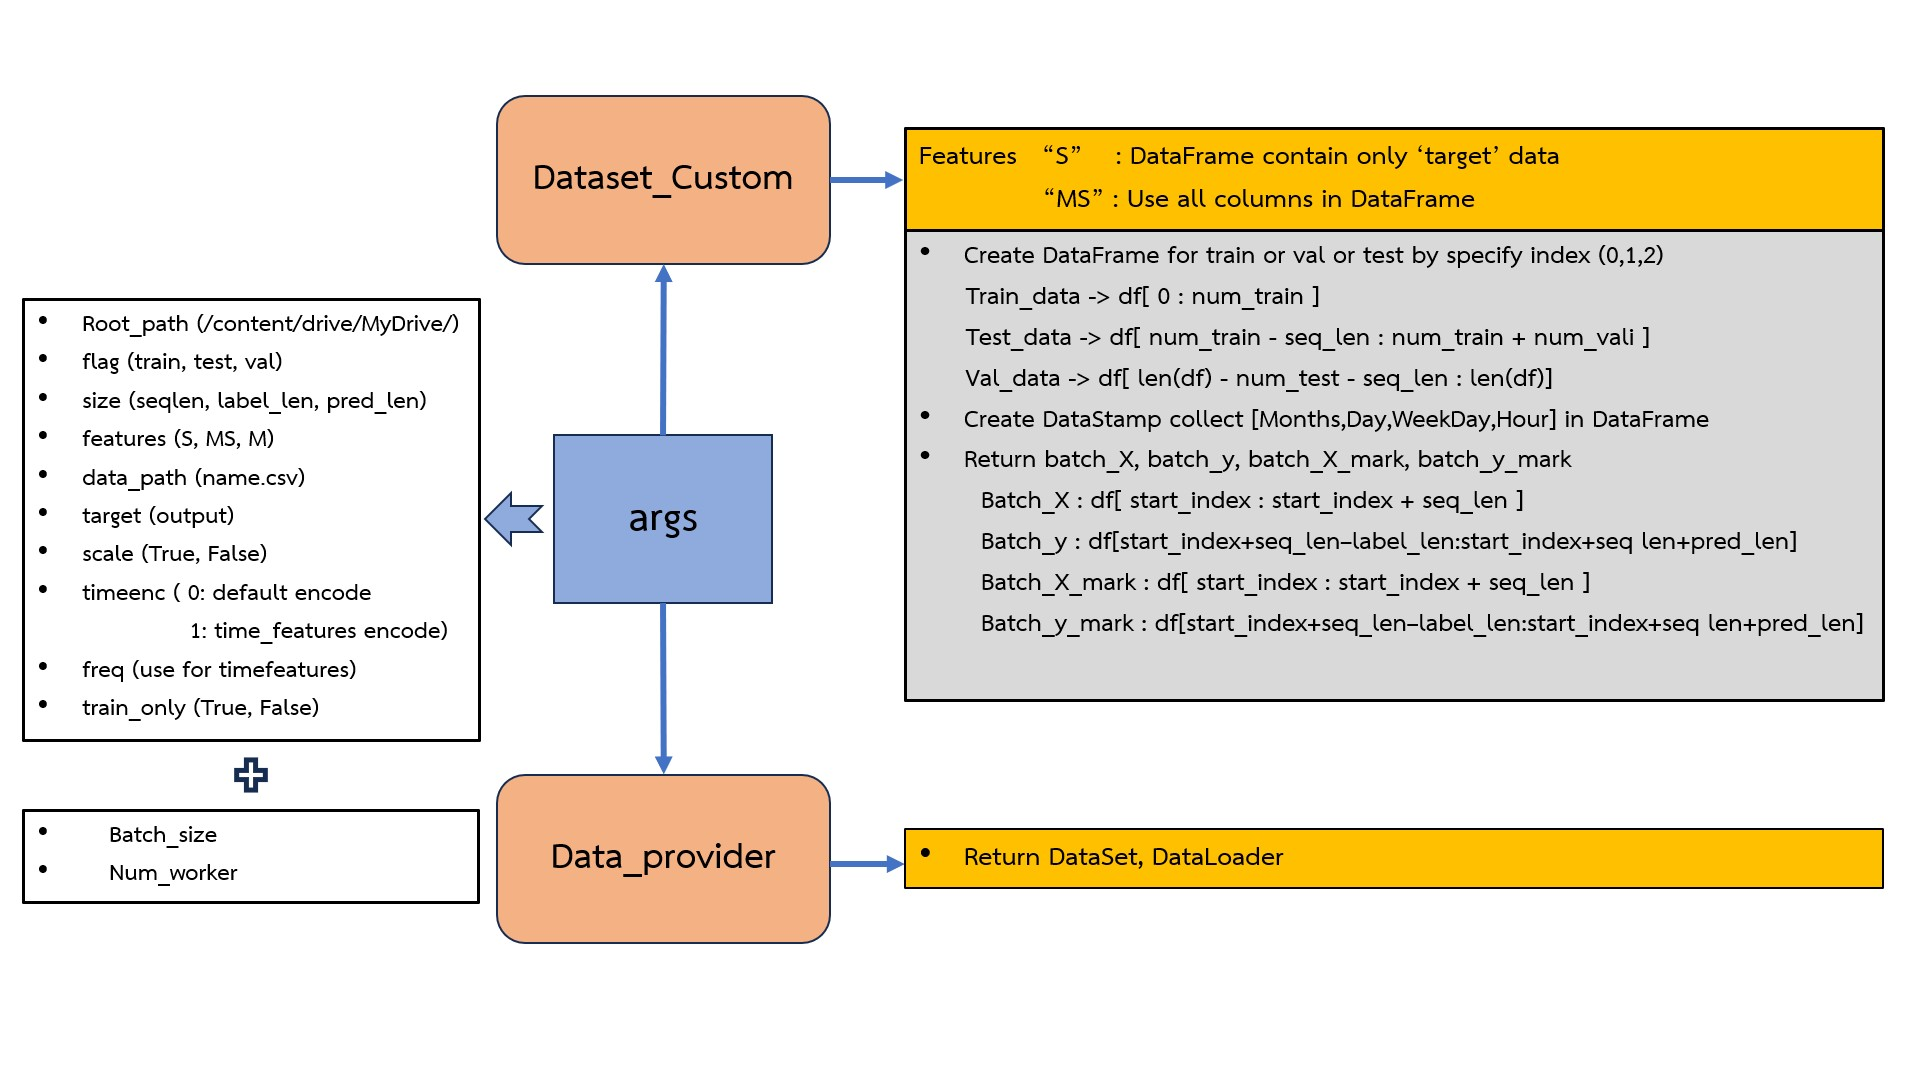

In [ ]:
def data_provider(args, flag):
    Data = Dataset_Custom(args)
    timeenc = 0 if args.embed != 'timeF' else 1
    train_only = args.train_only

    if flag == 'test':
        shuffle_flag = False
        drop_last = False
        batch_size = args.batch_size
        freq = args.freq
        data_set = Dataset_Custom(root_path=args.root_path,
                                                data_path=args.data_path,
                                                flag=flag,
                                                size=[args.seq_len, args.label_len, args.pred_len],
                                                features=args.features,
                                                target=args.target,
                                                timeenc=timeenc,
                                                freq=freq,
                                                train_only=train_only
                                                 )
    elif flag == 'pred':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = args.freq
        data_set = Dataset_Pred(args.root_path)
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

        data_set = Dataset_Custom(
            root_path=args.root_path,
            data_path=args.data_path,
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            target=args.target,
            timeenc=timeenc,
            freq=freq,
            train_only=train_only
        )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

# Embedding

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import math


class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                print(m.weight.shape)

    def forward(self, x):
        print(x.shape) # x = [B,Seq,channel]
        #x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        print(x.shape)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()

        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6, 'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)


class DataEmbedding_wo_pos(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_wo_pos, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)

class DataEmbedding_wo_pos_temp(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_wo_pos_temp, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x)
        return self.dropout(x)

class DataEmbedding_wo_temp(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_wo_temp, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)

# Model Dlinear Type "S"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class ModelDlinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(ModelDlinear, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

# exp main

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
%matplotlib inline
import os
import time

import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

import os
import torch
import numpy as np
import matplotlib.pyplot as plt


class Exp_Basic(object):
    def __init__(self, args):
        self.args = args
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        raise NotImplementedError
        return None

    def _acquire_device(self):
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(
                self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _get_data(self):
        pass

    def vali(self):
        pass

    def train(self):
        pass

    def test(self):
        pass


class Exp_Main(Exp_Basic):
    def __init__(self, args):
        super(Exp_Main, self).__init__(args)

    def _build_model(self):
        model = ModelDlinear(args)
        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(vali_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                      outputs = self.model(batch_x)
                else:
                      outputs = self.model(batch_x)

                f_dim = -1   # for "S" and "MS"
                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)

                pred = outputs.detach().cpu()
                true = batch_y.detach().cpu()

                loss = criterion(pred, true)

                total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        train_data, train_loader = self._get_data(flag='train')
        if not self.args.train_only:
            vali_data, vali_loader = self._get_data(flag='val')
            test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()


        for epoch in range(self.args.train_epochs):
            iter_count = 0
            train_loss = []

            self.model.train()
            epoch_time = time.time()
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                batch_x = batch_x.float().to(self.device)

                batch_y = batch_y.float().to(self.device)
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)


                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = self.model(batch_x)

                        f_dim = -1 # for "S" and "MS"
                        outputs = outputs[:, -self.args.pred_len:, f_dim:]
                        batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                        loss = criterion(outputs, batch_y)
                        train_loss.append(loss.item())
                else:
                    outputs = self.model(batch_x)
                    f_dim = -1 if self.args.features == 'MS' else 0
                    outputs = outputs[:, -self.args.pred_len:, f_dim:]
                    batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())

                if (i + 1) % 2000 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time() - time_now) / iter_count
                    left_time = speed * ((self.args.train_epochs - epoch) * train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()

                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)

            if not self.args.train_only:
                vali_loss = self.vali(vali_data, vali_loader, criterion)
                test_loss = self.vali(test_data, test_loader, criterion)

                print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                    epoch + 1, train_steps, train_loss, vali_loss, test_loss))
                early_stopping(vali_loss, self.model, path)
            else:
                print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f}".format(
                    epoch + 1, train_steps, train_loss))
                early_stopping(train_loss, self.model, path)

            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch + 1, self.args)



        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))

        return self.model

    def test(self, setting, test=0):
        test_data, test_loader = self._get_data(flag='test')

        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        inputx = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                      outputs = self.model(batch_x)
                else:
                      outputs = self.model(batch_x)

                f_dim = -1 # for "S" and "MS"

                outputs = outputs[:, -self.args.pred_len:, f_dim:]
                batch_y = batch_y[:, -self.args.pred_len:, f_dim:].to(self.device)
                outputs = outputs.detach().cpu().numpy()
                batch_y = batch_y.detach().cpu().numpy()

                pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
                true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

                preds.append(pred)
                trues.append(true)
                inputx.append(batch_x.detach().cpu().numpy())
                if i % 20 == 0:
                    input = batch_x.detach().cpu().numpy()
                    gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
                    pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
                    visual(gt, pd, os.path.join(folder_path, str(i) + '.pdf'))


        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        inputx = np.concatenate(inputx, axis=0)

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        mae, mse, rmse, mape, mspe, rse, corr = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))
        f = open("result.txt", 'a')
        f.write(setting + "  \n")
        f.write('mse:{}, mae:{}, rse:{}, corr:{}'.format(mse, mae, rse, corr))
        f.write('\n')
        f.write('\n')
        f.close()

        # np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe,rse, corr]))
        np.save(folder_path + 'pred.npy', preds)
        # np.save(folder_path + 'true.npy', trues)
        # np.save(folder_path + 'x.npy', inputx)
        return

    def predict(self, setting, load=False):
        pred_data, pred_loader = self._get_data(flag='pred')

        if load:
            path = os.path.join(self.args.checkpoints, setting)
            best_model_path = path + '/' + 'checkpoint.pth'
            self.model.load_state_dict(torch.load(best_model_path))

        preds = []

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float()
                batch_x_mark = batch_x_mark.float().to(self.device)
                batch_y_mark = batch_y_mark.float().to(self.device)

                if self.args.use_amp:
                    with torch.cuda.amp.autocast():
                      outputs = self.model(batch_x)
                else:
                      outputs = self.model(batch_x)

                pred = outputs.detach().cpu().numpy()  # .squeeze()
                preds.append(pred)

        preds = np.array(preds)
        preds = np.concatenate(preds, axis=0)
        preds = np.concatenate(preds, axis=0)
        if (pred_data.scale):
          preds = pred_data.inverse_transform(preds)
          preds = np.expand_dims(preds, axis=1)
          torch_preds = torch.tensor(preds).permute(1,0,2)
          preds = torch_preds.numpy()
        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        np.save(folder_path + 'real_prediction.npy', preds)
        pd.DataFrame(np.append(np.transpose([pred_data.future_dates]), preds[0], axis=1), columns=pred_data.cols[::7]).to_csv(folder_path + 'real_prediction.csv', index=False)

        return


# Setup argument

In [ ]:
class Arguments:
    def __init__(self, is_training, train_only, model_id, model, data, root_path, data_path, features,
                 target, freq, checkpoints, seq_len, label_len, pred_len, individual,embed_type, enc_in,
                 dropout, embed, activation, do_predict, num_workers, itr, train_epochs,
                 batch_size, patience, learning_rate, des, loss, lradj, use_amp, use_gpu, gpu, use_multi_gpu,
                 devices, test_flop):
        self.is_training = is_training
        self.train_only = train_only
        self.model_id = model_id
        self.model = model
        self.data = data
        self.root_path = root_path
        self.data_path = data_path
        self.features = features
        self.target = target#
        self.freq = freq#
        self.checkpoints = checkpoints
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len
        self.individual = individual
        self.embed_type = embed_type
        self.enc_in = enc_in
        # self.dec_in = dec_in
        # self.c_out = c_out
        # self.d_model = d_model
        # self.n_heads = n_heads
        # self.e_layers = e_layers
        # self.d_layers = d_layers
        # self.d_ff = d_ff
        # self.moving_avg = moving_avg
        # self.factor = factor
        # self.distil = distil
        self.dropout = dropout#
        self.embed = embed
        self.activation = activation#
        # self.output_attention = output_attention
        self.do_predict = do_predict
        self.num_workers = num_workers#
        self.itr = itr
        self.train_epochs = train_epochs
        self.batch_size = batch_size
        self.patience = patience
        self.learning_rate = learning_rate
        self.des = des
        self.loss = loss#
        self.lradj = lradj
        self.use_amp = use_amp
        self.use_gpu = use_gpu
        self.gpu = gpu
        self.use_multi_gpu = use_multi_gpu
        self.devices = devices
        self.test_flop = test_flop


# สร้างอ็อบเจ็กต์ของ DataArguments ด้วยค่าพารามิเตอร์ที่ต้องการ
# พวกformerทั้งหลาย

# args = Arguments(is_training=1,train_only=False, model_id='Iclr_96', model='Autoformer', data='Iclr',
#                  root_path='/content/drive/MyDrive/', data_path='updated_measurement_Iclr', features='MS', target='I',
#                  freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96,
#                  individual=True,embed_type=0, enc_in=7, dec_in=7, c_out=7, d_model=512, n_heads=8,
#                  e_layers=2,d_layers=1, d_ff=2048, moving_avg=25, factor=3, distil=True, dropout=0.05,
#                  embed='timeF', activation='gelu',output_attention=False, do_predict=True, num_workers=10, itr=1, train_epochs=1,
#                  batch_size=32, patience=5, learning_rate=0.005, des='Exp', loss='mse', lradj='type1',
#                  use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False,
#                  devices='0,1,2,3', test_flop=False
# )

args = Arguments(is_training=1,train_only=False, model_id='Iclr_96', model='DLinear', data='Iclr',
                 root_path='/content/drive/MyDrive/', data_path='updated_measurement_Iclr', features='S', target='I',
                 freq='t', checkpoints='./checkpoints/', seq_len=1344, label_len=96, pred_len=672,
                 individual=True,embed_type=0, enc_in=1, dropout=0.05,embed=None, activation='gelu',
                 do_predict=True, num_workers=4, itr=1, train_epochs=1,
                 batch_size=32, patience=5, learning_rate=0.005, des='Exp', loss='mse', lradj='type1',
                 use_amp=True, use_gpu=True, gpu=0, use_multi_gpu=False,
                 devices='0,1,2,3', test_flop=False
)
# args = Arguments(is_training=1,train_only=False, model_id='ETTh1_96', model='Autoformer', data='ETTh1',
#                  root_path='/content/drive/MyDrive/', data_path='ETTh1.csv', features='M', target='OT',
#                  freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96,
#                  individual=True,embed_type=0, enc_in=7, dec_in=7, c_out=7, d_model=512, n_heads=8,
#                  e_layers=2,d_layers=1, d_ff=2048, moving_avg=25, factor=3, distil=True, dropout=0.05,
#                  embed='timeF', activation='gelu',output_attention=True, do_predict=True, num_workers=10, itr=1, train_epochs=50,
#                  batch_size=32, patience=10, learning_rate=0.005, des='Exp', loss='mse', lradj='type1',
#                  use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False,
#                  devices='0,1,2,3', test_flop=False
# )



# Run

In [ ]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
Exp = Exp_Main

if args.is_training:
        # setting record of experiments
  setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_eb{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.embed,
            args.des)

  exp = Exp(args)  # set experiments
  print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
  exp.train(setting)


  if not args.train_only:
      print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
      exp.test(setting)

  if args.do_predict:
      print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
      exp.predict(setting, True)

  torch.cuda.empty_cache()
else:
  pass


Use GPU: cuda:0
>>>>>>>predicting : Iclr_96_DLinear_Iclr_ftS_sl1344_ll96_pl672_ebNone_Exp<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
pred 1


FileNotFoundError: ignored